In [10]:
pip install twstock

In [11]:
import twstock
import pandas as pd

stock_code = '2330'
stock = twstock.Stock(stock_code)

raw_data = stock.fetch_from(2014, 12)

dates = [entry[0] for entry in raw_data]  # 日期
prices = [entry[6] for entry in raw_data]  # 收盤價

data = pd.DataFrame({'date': dates, 'price': prices}).dropna()

print(data.head())

data.to_csv('tsmc_stock.csv', index=False)

        date  price
0 2014-12-01  140.0
1 2014-12-02  137.5
2 2014-12-03  138.0
3 2014-12-04  139.0
4 2014-12-05  137.5


In [12]:
data.head()

,date,price
0,2014-12-01,140.0
1,2014-12-02,137.5
2,2014-12-03,138.0
3,2014-12-04,139.0
4,2014-12-05,137.5


In [13]:
data.tail()

,date,price
2446,2024-12-09,1075.0
2447,2024-12-10,1065.0
2448,2024-12-11,1045.0
2449,2024-12-12,1060.0
2450,2024-12-13,1065.0


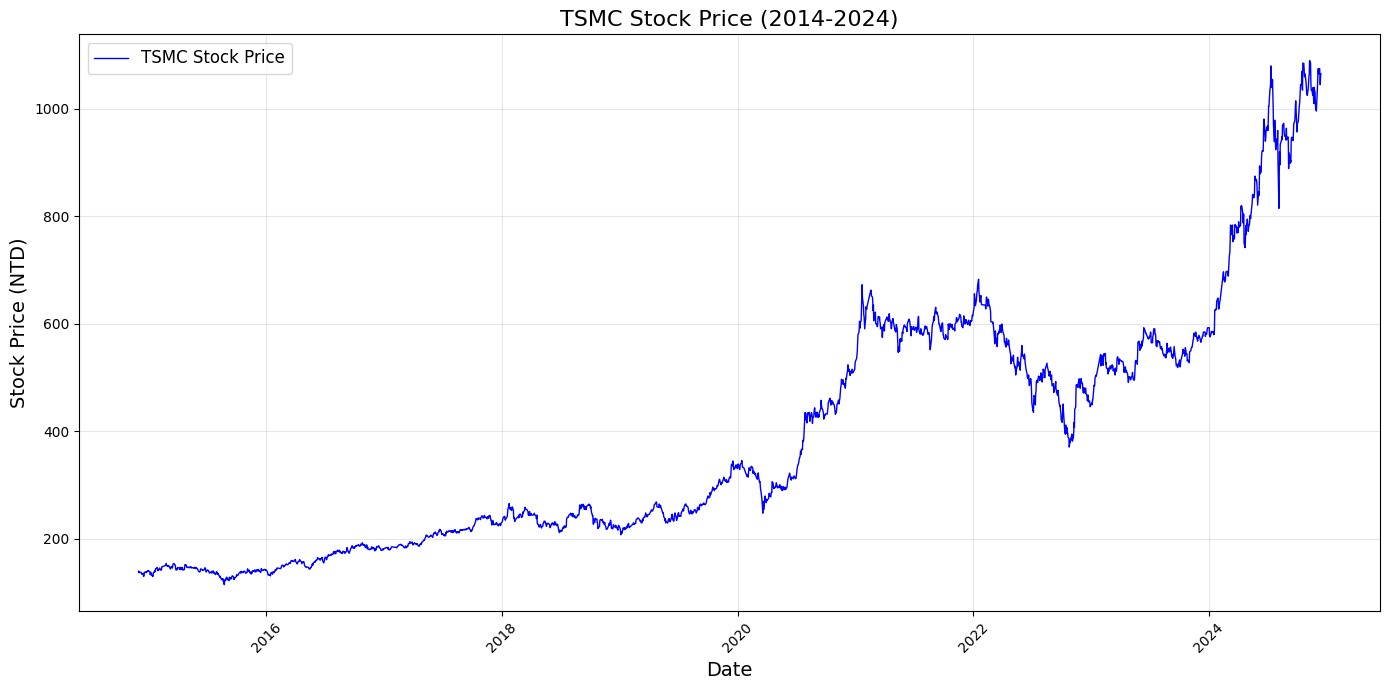

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['price'], label='TSMC Stock Price', color='blue', linewidth=1)
plt.title('TSMC Stock Price (2014-2024)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price (NTD)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import math

df_tsmc = pd.read_csv('tsmc_stock.csv', parse_dates=True, index_col='date')
df_tsmc = df_tsmc[['price']]

df_tsmc = df_tsmc.fillna(method='ffill')

<ipython-input-15-6066c3b0510f>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_tsmc = df_tsmc.fillna(method='ffill')


In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_tsmc['price'] = scaler.fit_transform(df_tsmc['price'].values.reshape(-1, 1))

def load_data(stock, look_back):
    data_raw = stock.values
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

look_back = 60
x_train, y_train, x_test, y_test = load_data(df_tsmc, look_back)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1913, 59, 1)
y_train.shape =  (1913, 1)
x_test.shape =  (478, 59, 1)
y_test.shape =  (478, 1)


In [17]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [18]:
y_train.size(),x_train.size()

(torch.Size([1913, 1]), torch.Size([1913, 59, 1]))

In [19]:
# LSTM 模型
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [20]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0:
        print(f"Epoch {t}, MSE: {loss.item():.4f}")
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch 0, MSE: 0.4018
Epoch 10, MSE: 0.0841
Epoch 20, MSE: 0.0117
Epoch 30, MSE: 0.0042
Epoch 40, MSE: 0.0021
Epoch 50, MSE: 0.0014
Epoch 60, MSE: 0.0011
Epoch 70, MSE: 0.0008
Epoch 80, MSE: 0.0007
Epoch 90, MSE: 0.0006


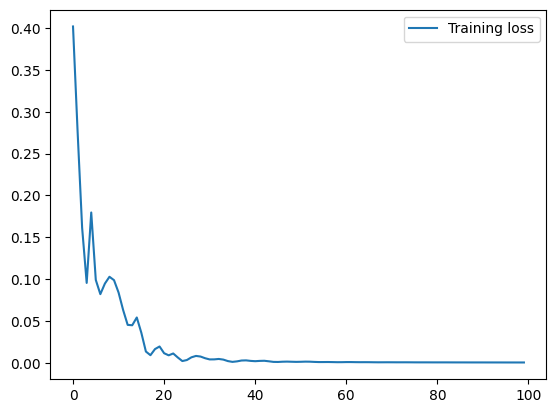

In [21]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [22]:
y_test_pred = model(x_test).detach().numpy()

y_train_pred = scaler.inverse_transform(model(x_train).detach().numpy())
y_train = scaler.inverse_transform(y_train.numpy())
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test.numpy())

train_score = math.sqrt(mean_squared_error(y_train, y_train_pred))
test_score = math.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Train Score: {train_score:.2f} RMSE")
print(f"Test Score: {test_score:.2f} RMSE")

Train Score: 11.82 RMSE
Test Score: 135.03 RMSE


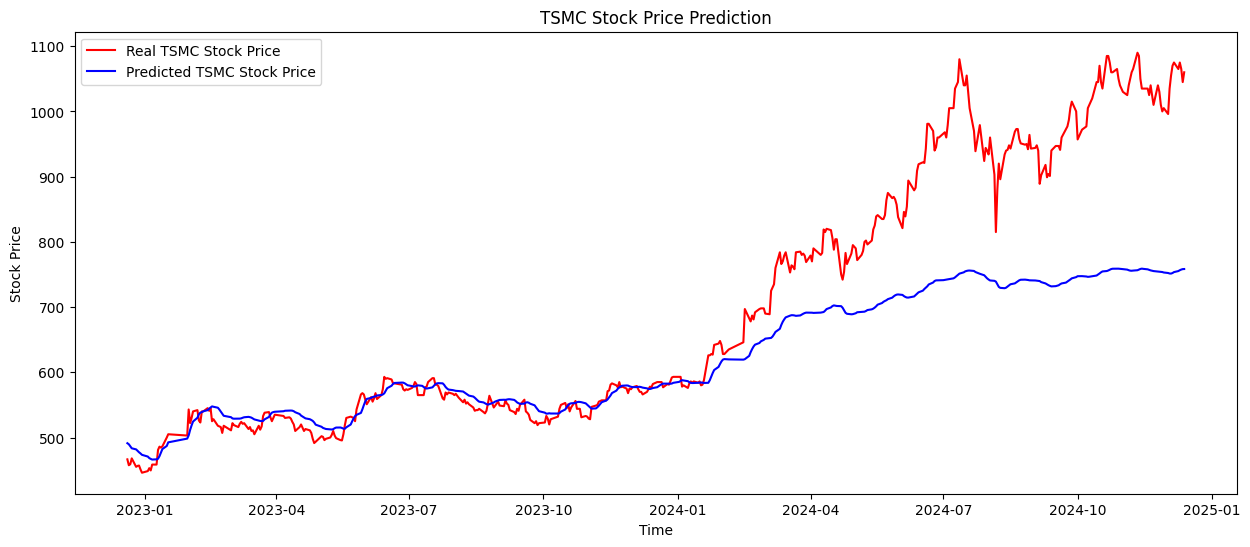

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(df_tsmc.index[-len(y_test):], y_test, color='red', label='Real TSMC Stock Price')
plt.plot(df_tsmc.index[-len(y_test):], y_test_pred, color='blue', label='Predicted TSMC Stock Price')
plt.title('TSMC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()